This notebook contains the kernal codes and funtions implementation. You can run below code cell directly to see the overlay result after typing into the selfie path and glasses url. 

Besides, you can also do the fine tunning or other modification here as it's quick to get feedback on notebook.

#### Note
1. Glasses image should be type of .png or .webp as this program needs glasses images have alpha channel. If The extension of galsses image is .jpg or .jepg, then this demo will not working. But if run demo/run_demo.py, it still return a ovelay result with unexpected effect even though glasses image url ends with .jpeg or .jpg.
2. You can read docs/technical_document.md file to get ideas expalined in details.

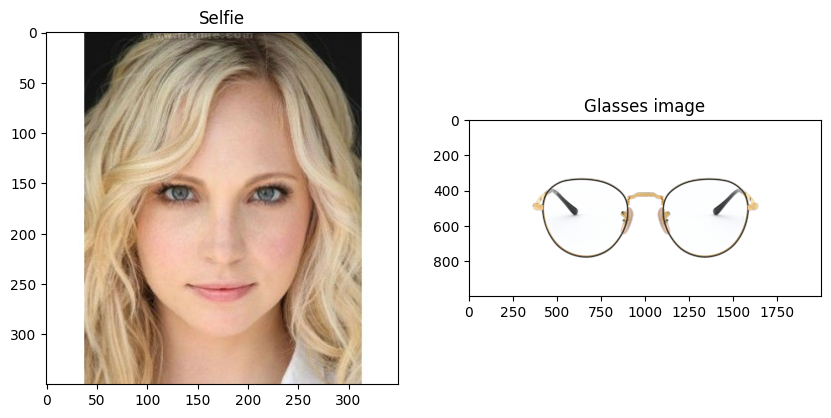

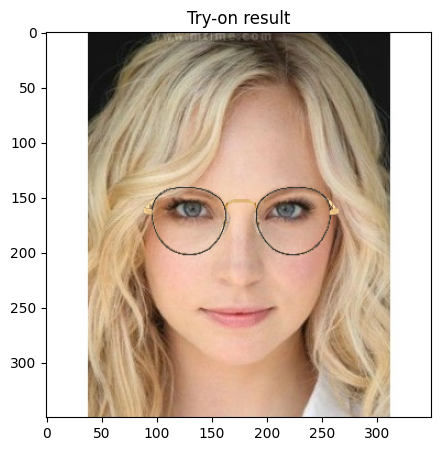

Virtual Try On Done!


In [ ]:
# Method BEST one
import cv2
import numpy as np
import mediapipe as mp
import urllib.request
import matplotlib.pyplot as plt

def compute_glasses_center(img_rgba: np.ndarray, upper_area_ratio: float =0.4) -> np.ndarray:
    """
    Summary: Compute the visual center point (C2) of a pair of glasses from an RGBA image.
    img_rgba: glasses image whose mode is rgba
    upper_area_ratio: a threshold ratio, the proportion of lens height used for computing top-center.
    """
    alpha = img_rgba[:, :, 3]
    ys, xs = np.where(alpha > 0)  

    top, bottom = ys.min(), ys.max()
    left, right = xs.min(), xs.max()

    y_mid = top + (bottom - top) / 2  # Upper one-third line

    # Left lens
    is_left = xs < (left + right) / 2 # Identifies which pixels belong to the left half of the frame.
    pts_l = np.vstack([xs[is_left], ys[is_left]]).T
    # upper_area_ratio is 0.4 by default.
    # It means to keep only the upper 40% of the left lens area — likely around the top of the actual lens.
    # It’s a tunable hyperparameter. 
    # We can change it to adjust how much of the lens height is used to compute the center.
    pts_l_top = pts_l[pts_l[:,1] < top + (bottom - top)*upper_area_ratio]
    # Calculates the average point (center) of the left lens top area.
    C_left = pts_l_top.mean(axis=0) if len(pts_l_top)>0 else np.array([left, y_mid])

    # Right lens
    is_right = ~is_left
    pts_r = np.vstack([xs[is_right], ys[is_right]]).T
    pts_r_top = pts_r[pts_r[:,1] < top + (bottom - top)*upper_area_ratio]
    C_right = pts_r_top.mean(axis=0) if len(pts_r_top)>0 else np.array([right, y_mid])

    return (C_left + C_right) / 2  # float center of the frame

def remove_lens_region(img_rgba: np.ndarray) -> np.ndarray:
    """
    Removes the glasses' lens region (including anything inside, like temple arms) from an RGBA image  and make lens region transparent 
    by setting those areas to transparent (alpha = 0),
    while preserving the frame and other regions.
    """
    # Check if the image contains an alpha channel
    if img_rgba.shape[2] != 4:
        print("Warning: Image has no alpha channel. Skipping processing.")
        return img_rgba

    # Extract the alpha channel
    alpha = img_rgba[:, :, 3]

    # Convert image from BGRA to BGR
    rgb = cv2.cvtColor(img_rgba, cv2.COLOR_BGRA2BGR)

    # Convert image from BGR to HSV color space
    hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)

    # Define lens color range and create mask
    # H: 0~180 means accepting all the hues
    # S: 0~30 means low saturation, close to gray-white, with a high level of transparentcy and lens highlight
    # V: 200~255 means highlight area (eg, refective lens)
    # This detects very bright, low-saturation areas — typical of reflective or transparent lens zones.
    # Because Lens regions usually appear light-colored or whitish, which have: Low Saturation (S) and High Brightness (V)
    # Temple arms that appear inside the lens will often be captured too, because they become lighter when overlaid on bright lenses.
    lower_bound = np.array([0, 0, 200])
    upper_bound = np.array([180, 30, 255])
    mask_lens = cv2.inRange(hsv, lower_bound, upper_bound)

    # Use morphological operations to remove small noise
    kernel = np.ones((5, 5), np.uint8)
    mask_lens = cv2.morphologyEx(mask_lens, cv2.MORPH_OPEN, kernel)

    # Find contours of the lens region
    contours, _ = cv2.findContours(mask_lens, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a fully transparent mask with the same size as the original alpha channel
    transparent_mask = np.zeros_like(alpha, dtype=np.uint8)

    # Compute the convex hull for each contour and fill the transparent mask
    # Convex hull smooths out the lens region, removing dents and gaps (such as small structures of temple arms).
    # This ensures a solid transparent lens area, without leftover bits inside.
    for contour in contours:
        convex_hull = cv2.convexHull(contour)
        cv2.fillPoly(transparent_mask, [convex_hull], 255)

    # Apply the transparent mask to the alpha channel to make the lens region transparent
    # If transparent_mask == 255, i.e., this pixel is in the lens region, then set alpha=0; else keep original alpha value
    img_rgba[:, :, 3] = np.where(transparent_mask == 255, 0, alpha)

    return img_rgba

def rotate_galsses_image(img_rgba: np.ndarray, angle) -> np.ndarray:
    (h, w) = img_rgba.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    return cv2.warpAffine(img_rgba, M, (w, h), flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))

def rotate_pt(pt, center, angle):
    """ This function rotates a 2D point pt around a given center by a given angle (in degrees) """
    # Converts the rotation angle from degrees to radians, 
    # since numpy trigonometric functions work in radians.
    ang = np.deg2rad(angle)
    # Builds a 2D rotation matrix
    R = np.array([[np.cos(ang), -np.sin(ang)],
                  [np.sin(ang),  np.cos(ang)]])
    return (R.dot(pt - center) + center)

# ---------- STEP3: Detect keypoints using MediaPipe ----------
def line_intersection(point_1, line_vec_1, point_2, line_vec_2):
    """Compute the intersection point of two lines"""
    A = np.array([line_vec_1, -line_vec_2]).T
    if np.linalg.matrix_rank(A) < 2:
        return (point_1 + point_2) / 2
    b = point_2 - point_1
    t_s = np.linalg.solve(A, b)
    return point_1 + t_s[0] * line_vec_1

def get_keypoints(face_img: np.ndarray) -> dict:
    """
    Use MediaPipe to detect facial landmarks
    and calculate useful points for positioning glasses
    in a virtual try-on system.
    """
    mp_face = mp.solutions.face_mesh
    FACE_LMS = mp_face.FaceMesh(static_image_mode=True)

    h, w = face_img.shape[:2]
    res = FACE_LMS.process(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
    # If no face landmarks were detected, raise an error.
    if not res.multi_face_landmarks:
        raise ValueError("No face detected")
    # Get the face's landmarks.
    lm = res.multi_face_landmarks[0]

    """
    pt(i) is an utility Function to Convert a Landmark to coordinate (x, y)
    Converts a landmark index i into an image coordinate [x, y]
    by scaling the normalized values (from 0–1) to pixel space.
    """
    def pt(i): return np.array([lm.landmark[i].x * w, lm.landmark[i].y * h])

    # Eye centers
    L_eye_center = (pt(33) + pt(133)) / 2
    R_eye_center = (pt(362) + pt(263)) / 2

    # Nose bridge: tip and root
    nose_tip = pt(1)
    nose_root = pt(168)
    nose_center = (nose_tip + nose_root) / 2 # the midpoint between tip and root (used as a helper point).

    # Eye line vector
    eye_line_vec = R_eye_center - L_eye_center
    eye_line_point = L_eye_center

    # Nose bridge line vector
    nose_vec = nose_tip - nose_root
    nose_point = nose_center

    # Compute intersection point of the eye_line_vec and nose_vec as face center C1
    C1 = line_intersection(eye_line_point, eye_line_vec, nose_point, nose_vec)

    return {
        'L_eye': L_eye_center,
        'R_eye': R_eye_center,
        'L_ear': pt(234),
        'R_ear': pt(454),
        'C1': C1
    }

def overlay_images(gl2: np.ndarray, face: np.ndarray, x: int, y: int):
    """ 
    Overlay the RGBA glasses image gl2 onto the face image at position (x, y).
    gl2: The transformed (scaled + rotated) glasses image with alpha channel.
    face: The original face image (typically BGR or RGB, no alpha).
    x, y: The top-left coordinates where the glasses should be placed.
    """
    h2, w2 = gl2.shape[:2]

    out = face.copy() # Creates a copy of the face image to avoid modifying the original.
    galsses = gl2
    fg = galsses[:, :, 3] / 255   # foreground mask

    # Crop to avoid out-of-bounds
    H, W = out.shape[:2]
    x1 = max(x, 0)
    y1 = max(y, 0)
    x2 = min(x + w2, W)
    y2 = min(y + h2, H)

    ox1 = x1 - x
    oy1 = y1 - y
    ox2 = ox1 + (x2 - x1)
    oy2 = oy1 + (y2 - y1)

    # Performs alpha blending for each channel c
    # fg[] * glasses[] gives the foreground contribution.
    # (1 - fg[]) * out[]) gives the background (face image) contribution.
    # Result: semi-transparent blending of the glasses image on top of the face image.
    for c in range(3):
        out[y1:y2, x1:x2, c] = fg[oy1:oy2, ox1:ox2] * galsses[oy1:oy2, ox1:ox2, c] + \
                               (1 - fg[oy1:oy2, ox1:ox2]) * out[y1:y2, x1:x2, c]
    return out

def smooth_frame_edge(img_rgba: np.ndarray,
                      white_thresh: int = 220,
                      alpha_thresh: int = 150,
                      kernel_size: int = 3) -> np.ndarray:
    """
    Smooth the frame edgae by strongly cleaning white fringe and semi-transparent noisy edges on thin glasses frames.
    """
    if img_rgba.shape[2] != 4:
        return img_rgba

    result = img_rgba.copy()
    rgb = result[:, :, :3]
    alpha = result[:, :, 3]

    # Step 1: Detect low-alpha fringe region
    fringe_mask = np.logical_and(
        alpha < alpha_thresh,
        np.all(rgb > white_thresh, axis=2)
    ).astype(np.uint8) * 255

    # Step 2: Morphological open to refine mask
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    refined_mask = cv2.morphologyEx(fringe_mask, cv2.MORPH_OPEN, kernel)

    # Step 3: Apply refined mask: set those pixels fully transparent
    result[refined_mask == 255] = [0, 0, 0, 0]

    return result


# ---------------- Main function for try-on ----------------
def main_tryon(selfie_path: str, glasses_url: str, gl_base_sacle_param: float = 1.5, gl_upward_pixels: int =10):
    """_summary_
    selfie_path: image path of selfie
    glasses_url: image url of glasses
    gl_base_sacle_param: the base scale amount which glasses are resized at, defaults to 1.5
    gl_upward_pixels: the pixels value which glasses are moved upforward, defaults to 10
    """
    # ---------- STEP1: Load selfie and frame ----------
    # Load selfie
    face = cv2.imread(selfie_path)  # (H, W, 3)
    # Visualize selfie
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)    
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    plt.title('Selfie')

    # Load glasses from URL directly
    resp = urllib.request.urlopen(glasses_url)
    img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
    gl = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)  # (H, W, 4)
    
    # Visualize the glasses
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(gl, cv2.COLOR_BGRA2RGBA))
    plt.title('Glasses image')


    # ---------- STEP2 Detect face keypoints using MediaPipe ----------
    # Calculate keypoints
    kp = get_keypoints(face)
    C1 =  kp['C1']  # Get the center of the face
    ear_dist = np.linalg.norm(kp['R_ear'] - kp['L_ear'])
    # Get the angle at which the selfie tilts
    angle = np.degrees(np.arctan2(kp['R_eye'][1] - kp['L_eye'][1],
                                  kp['R_eye'][0] - kp['L_eye'][0]))


    # ---------- STEP3: Make the frame lens transparent ----------
    gl = remove_lens_region(gl)
    gl = smooth_frame_edge(gl, white_thresh=200, alpha_thresh=180, kernel_size=2) # This effect of this function is not good


    # ---------- STEP4: Resize and rotate the frame relative to the face ----------
    # Compute the frame center; And scale, rotate frame
    C2 = compute_glasses_center(gl)
    scale = (ear_dist * gl_base_sacle_param) / gl.shape[1]
    # Resizes the glasses image gl by scale in both width and height.
    gl2 = cv2.resize(gl, (0,0), fx=scale, fy=scale)

    # a negative angle means clockwise rotation.
    gl2 = rotate_galsses_image(gl2, -angle)


    # ---------- STEP5: Overlay frame onto face ----------
    # Align frame center C2 with face center C1
    h2, w2 = gl2.shape[:2]
    rel = C2 * scale  # Scales the original glasses center C2 by the same factor as the image.
    # Rotates the scaled glasses center point rel around the center of the rotated image.
    C2r = rotate_pt(rel, np.array([w2/2, h2/2]), -angle)
    top_left = C1 - C2r
    top_left[1] -= gl_upward_pixels  # Shift upward some pixels (10 pixels by default) to avoid covering eyes, for a more realistic effect.
    x, y = int(top_left[0]), int(top_left[1])

    # Overlay the transformed glasses gl2 on top of the face image at coordinates (x, y).
    out = overlay_images(gl2, face, x, y)
    
    # ---------- STEP6: Display and save results ----------
    # plt.subplot(2,2,3)
    plt.figure(figsize=(8,5))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title('Try-on result')
    plt.show()
    print("Virtual Try On Done!")
    

# ---------- Demo here ----------
# Get the glasses urls from given PostgreSQL table (column: main_image)
glasses_urls = [
    "https://optiker-bode.de/sites/default/files/2022-10/0RX4378V__8172_000A.png",
    "https://optiker-bode.de/sites/default/files/2022-10/0RX6448__3086_000A.png",
    "https://optiker-bode.de/sites/default/files/2024-04/0RX6466__2904_000A.png",
    "https://optiker-bode.de/sites/default/files/2021-07/0RX1972V__2943_000A.png",
    "https://optiker-bode.de/sites/default/files/2021-07/0RX6536__3086_000A.png",
    "https://optiker-bode.de/sites/default/files/2021-08/0RX3582V__2946_000A.png",
    "https://optiker-bode.de/sites/default/files/2021-08/0RX5380__5947_000A.png"
    #,"https://optiker-bode.de/sites/default/files/2024-05/F_4549567221023_000.jpeg"
]

# Replace these with your selfie paths
selfie_paths = [
  "selfies/CM200.jpg",
  "selfies/CM246.jpg",
  "selfies/CF537.jpg",
  "selfies/CF252.jpg",
  "selfies/AF108.jpg",
  "selfies/AM421.jpg",
  "selfies/CF8.jpg"
]

selfie = selfie_paths[-1]
gl_url = glasses_urls[5]
main_tryon(selfie, gl_url)
